In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasRegressor

In [2]:
df = pd.read_csv('processedcsv/combinedstats.csv')
df.dropna(inplace=True)
df['age'] = df[['season', 'birthDate']].apply(lambda x: int(x['season'][:4]) - int(x['birthDate'][:4]), axis=1)
X = df.drop(['player_id', 'firstName', 'lastName', 'season', 'salary', 'avgTimeOnIce', 'avgPowerPlayTimeOnIce', 'avgShortHandedTimeOnIce', 'birthDate'], axis=1)
y = df.filter(['salary'])

In [3]:
onehot = OneHotEncoder()
X['isD'] = X['primaryPosition'].apply(lambda x: 1 if x == 'D' else 0)
X['isRW'] = X['primaryPosition'].apply(lambda x: 1 if x == 'RW' else 0)
X['isLW'] = X['primaryPosition'].apply(lambda x: 1 if x == 'LW' else 0)
X['shootsL'] = X['shootsCatches'].apply(lambda x: 1 if x == 'L' else 0)
X_new = X.drop(['primaryPosition','shootsCatches'], axis=1)
X_normalized=(X_new-X_new.min())/(X_new.max()-X_new.min())

gamesPlayed     goals   assists    points  pointsPerGame  plusMinus  \
0        0.915663  0.320755  0.344828  0.367188       0.203333   0.452632   
1        0.566265  0.018868  0.149425  0.109375       0.096667   0.547368   
2        0.180723  0.000000  0.000000  0.000000       0.000000   0.452632   
3        0.819277  0.245283  0.241379  0.265625       0.163333   0.273684   
4        0.168675  0.000000  0.022989  0.015625       0.043333   0.431579   
...           ...       ...       ...       ...            ...        ...   
5187     0.132530  0.018868  0.000000  0.007812       0.026667   0.473684   
5188     0.012048  0.000000  0.000000  0.000000       0.000000   0.484211   
5189     0.180723  0.000000  0.000000  0.000000       0.000000   0.452632   
5190     0.433735  0.037736  0.034483  0.039062       0.046667   0.536842   
5191     0.686747  0.094340  0.057471  0.078125       0.056667   0.473684   

         shots  shootingPercentage  penaltyMinutes  timeOnIce  ...  \
0     0.423174              0.1006        0.201681   0.568492  ...   
1     0.113350              0.0217        0.075630   0.356324  ...   
2     0.022670              0.0000        0.008403   0.079493  ...   
3     0.284635              0.1140        0.050420   0.511394  ...   
4     0.030227              0.0000        0.084034   0.115677  ...   
...        ...                 ...             ...        ...  ...   
5187  0.035264              0.0667        0.016807   0.050873  ...   
5188  0.000000              0.0000        0.000000   0.005088  ...   
5189  0.020151              0.0000        0.008403   0.043210  ...   
5190  0.055416              0.0870        0.008403   0.152985  ...   
5191  0.133501              0.0926        0.025210   0.235664  ...   

      powerPlayTimeOnIce  shortHandedGoals  shortHandedAssists  \
0               0.462453               0.0            0.000000   
1               0.247545               0.0            0.000000   
2               0.018752               0.0            0.000000   
3               0.359338               0.0            0.333333   
4               0.000169               0.0            0.000000   
...                  ...               ...                 ...   
5187            0.000423               0.0            0.000000   
5188            0.000000               0.0            0.000000   
5189            0.000085               0.0            0.000000   
5190            0.002794               0.0            0.000000   
5191            0.050669               0.0            0.000000   

      shortHandedPoints  shortHandedTimeOnIce       age  isD  isRW  isLW  \
0              0.000000              0.001885  0.888889  0.0   1.0   0.0   
1              0.000000              0.057405  0.814815  1.0   0.0   0.0   
2              0.000000              0.002183  0.777778  1.0   0.0   0.0   
3              0.222222              0.371471  0.740741  0.0   0.0   0.0   
4              0.000000              0.180253  0.740741  1.0   0.0   0.0   
...                 ...                   ...       ...  ...   ...   ...   
5187           0.000000              0.003324  0.185185  0.0   0.0   1.0   
5188           0.000000              0.000000  0.296296  0.0   1.0   0.0   
5189           0.000000              0.003473  0.148148  0.0   0.0   1.0   
5190           0.000000              0.010171  0.296296  0.0   0.0   1.0   
5191           0.000000              0.013148  0.333333  0.0   0.0   0.0   

      shootsL  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
...       ...  
5187      1.0  
5188      1.0  
5189      1.0  
5190      1.0  
5191      0.0  

[5192 rows x 32 columns]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=5)

In [5]:
model_names = []
model_mse = []
model_rmse = []
model_rmse_cv = []
model_mae = []
model_r2 = []
results = y_test.copy()

### Lasso

In [6]:
clf = Lasso()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Lasso')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
model_rmse_cv.append(cross_val_score(clf, X_test, y_test, cv=5))
results['Lasso pred'] = y_pred.tolist()

### Ridge

In [7]:
clf = Ridge()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Ridge')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Ridge pred'] = y_pred

### Decision Tree

In [8]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Decision Tree')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Decision Tree pred'] = y_pred.tolist()

### XGBoost

In [9]:
clf = XGBRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('XGBoost')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['XGBoost pred'] = y_pred.tolist()

### Baseline Model

In [10]:
def get_model():
    model = Sequential()
    model.add(Dense(34, input_dim= 34, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Baseline')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Baseline pred'] = y_pred

Finished training 200 epochs


### Deep Model

In [11]:
def get_model():
    model = Sequential()
    model.add(Dense(34, input_dim= 34, activation='relu'))
    model.add(Dense(17, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Deep')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Deep pred'] = y_pred

Finished training 200 epochs


### Wide Model

In [12]:
def get_model():
    model = Sequential()
    model.add(Dense(40, input_dim= 34, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Wide')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Wide pred'] = y_pred

Finished training 200 epochs


In [13]:
results.head()

salary    Lasso pred    Ridge pred  Decision Tree pred  XGBoost pred  \
4829  6375000  4.534963e+06  4.409360e+06           7250000.0    6314443.00   
4403  5000000  4.004363e+06  4.080709e+06           4100000.0    4954547.00   
4041   650000  2.476883e+06  2.578879e+06           2000000.0    2327889.50   
3665  1450000  1.572326e+06  1.647579e+06            800000.0    1118489.50   
3844  1975000  1.687327e+06  1.700710e+06            625000.0    1179101.25   

      Baseline pred    Deep pred   Wide pred  
4829     3405492.50  4219169.000  3551375.00  
4403     2665492.25  4032549.500  2768349.75  
4041     2630904.75  3179636.500  2739586.75  
3665     1510985.25  1585793.250  1544951.00  
3844     2535900.00  1963118.625  2612092.75

In [14]:
data = {'model_name': model_names, 'model_mse': model_mse, 'model_rmse': model_rmse, 'model_mae': model_mae, 'model_r2': model_r2}
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.sort_values(by='model_rmse')

model_name     model_mse    model_rmse     model_mae  model_r2
3        XGBoost  1.641936e+12  1.281380e+06  8.430540e+05  0.648642
0          Lasso  1.875064e+12  1.369330e+06  9.991557e+05  0.598755
1          Ridge  1.876932e+12  1.370012e+06  9.966290e+05  0.598355
5           Deep  2.050872e+12  1.432087e+06  1.033672e+06  0.561133
2  Decision Tree  2.577487e+12  1.605456e+06  9.787410e+05  0.448443
6           Wide  3.051715e+12  1.746916e+06  1.391660e+06  0.346963
4       Baseline  3.109027e+12  1.763243e+06  1.389018e+06  0.334699

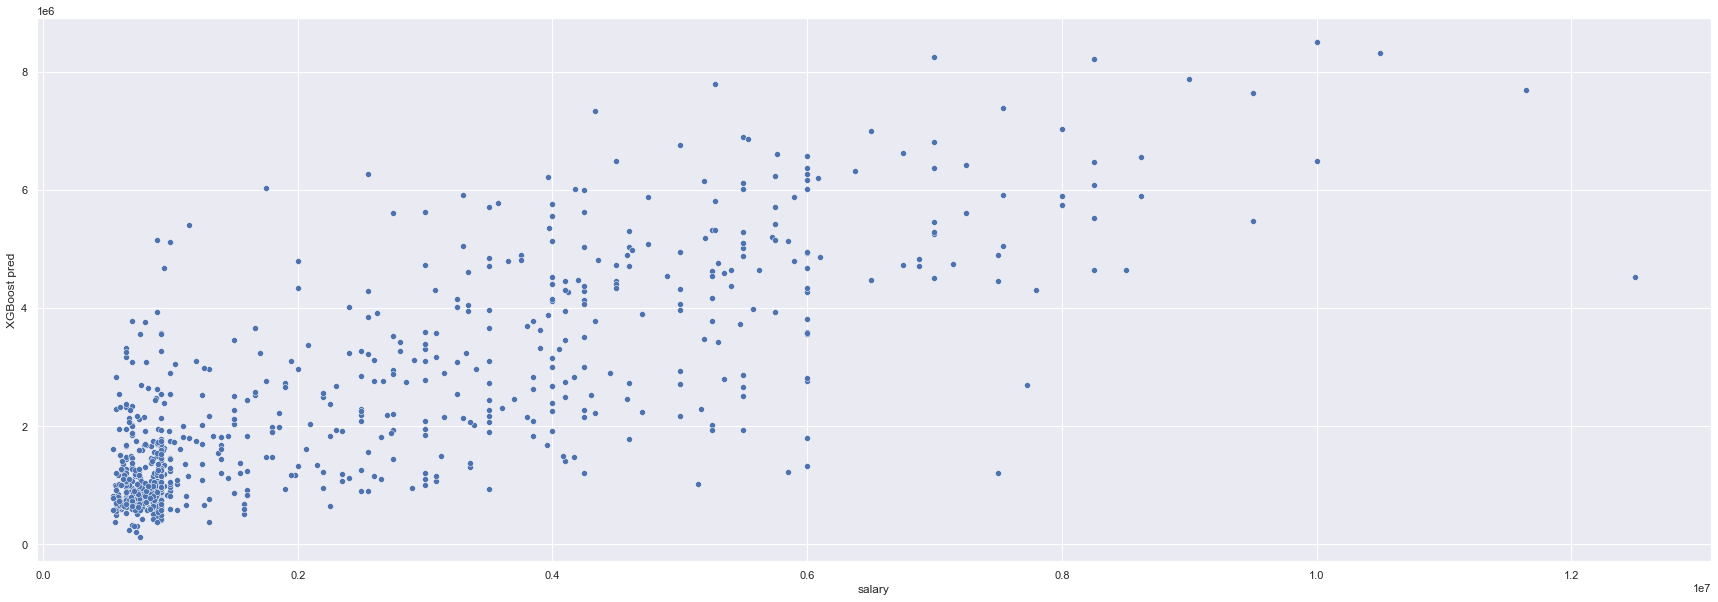

In [21]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.scatterplot(x='salary', y='XGBoost pred', data=results);

In [16]:
clf = XGBRegressor()
selector = RFE(clf, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

In [17]:
for feature in zip(X_train.columns, selector.get_support()):
    if (feature[1] == True):
        print(feature)

('pointsPerGame', True)
('timeOnIce', True)
('faceOffWins', True)
('faceOffLosses', True)
('faceOffPercentage', True)
('blocks', True)
('giveaways', True)
('powerPlayTimeOnIce', True)
('shortHandedTimeOnIce', True)
('age', True)


In [18]:
clf.fit(X_train, y_train)
for feature in zip(X_train.columns, clf.feature_importances_):
    print(feature)

('isC', 0.0014945485)
('isD', 0.010779047)
('isLW', 0.005452178)
('isRW', 0.005696511)
('shootsL', 0.008457275)
('shootsR', 0.0)
('gamesPlayed', 0.014973028)
('goals', 0.008464725)
('assists', 0.0106906425)
('points', 0.011471693)
('pointsPerGame', 0.058527008)
('plusMinus', 0.014001839)
('shots', 0.02814833)
('shootingPercentage', 0.010887391)
('penaltyMinutes', 0.010281521)
('timeOnIce', 0.035684254)
('faceOffWins', 0.022742055)
('faceOffLosses', 0.018727574)
('faceOffTaken', 0.0137217725)
('faceOffPercentage', 0.01270797)
('hits', 0.012558795)
('blocks', 0.028391516)
('takeaways', 0.01795814)
('giveaways', 0.026167814)
('turnoverDifferential', 0.011639815)
('powerPlayGoals', 0.010841217)
('powerPlayAssists', 0.016155016)
('powerPlayPoints', 0.018471254)
('powerPlayTimeOnIce', 0.35221502)
('shortHandedGoals', 0.0048663067)
('shortHandedAssists', 0.00892822)
('shortHandedPoints', 0.009653248)
('shortHandedTimeOnIce', 0.019205565)
('age', 0.16003875)


### Removing Redundant Features
Features in _italics_ are candidates to be dropped

Features in **bold** were in the 10 selected by RFE

Position features:
1. _('isC', 0.0014945485)_
1. ('isD', 0.010779047)
1. ('isLW', 0.005452178)
1. ('isRW', 0.005696511)

Handedness features:
1. ('shootsL', 0.008457275)
1. _('shootsR', 0.0)_

Scoring features:
1. _('goals', 0.008464725)_
1. ('assists', 0.0106906425)
1. ('points', 0.011471693)
1. **('pointsPerGame', 0.058527008)**

Shooting features:
1. ('shots', 0.02814833)
1. ('shootingPercentage', 0.010887391)

Powerplay scoring features:
1. _('powerPlayGoals', 0.010841217)_
1. ('powerPlayAssists', 0.016155016)
1. ('powerPlayPoints', 0.018471254)

Shorthanded scoring features:
1. _('shortHandedGoals', 0.0048663067)_
1. ('shortHandedAssists', 0.00892822)
1. ('shortHandedPoints', 0.009653248)

Faceoff features:
1. **('faceOffWins', 0.022742055)**
1. **('faceOffLosses', 0.018727574)**
1. _('faceOffTaken', 0.0137217725)_
1. **_('faceOffPercentage', 0.01270797)_**

Turnover features:
1. ('takeaways', 0.01795814)
1. ('giveaways', 0.026167814)
1. _('turnoverDifferential', 0.011639815)_

Non-redundant features:
1. ('plusMinus', 0.014001839)
1. ('penaltyMinutes', 0.010281521)
1. **('timeOnIce', 0.035684254)**
1. ('hits', 0.012558795)
1. **('blocks', 0.028391516)**
1. **('powerPlayTimeOnIce', 0.35221502)**
1. **('shortHandedTimeOnIce', 0.019205565)**
1. **('age', 0.16003875)**

Interestingly, there a number of observations that would be contradictory to one's assumptions.
First, goals seem to the feature with the lowest importance score in even strength, powerplay and shorthanded situations. Goals are the only way to score to win games, but according to the importance scores they are not as important as assists or total number of points.

Secondly, faceoffs seem to have a high importance score as faceoff wins, losses and win percentage are in the 10 features selected by RFE, and are three of the features with the highest importance score.

Lastly, time on ice seems to also be an important factor in salary as time on ice in all conditions (even strength, powerplay and shorthanded) are among the top features by importance score and from RFE.

In [19]:
X_train_new = X_train.drop(['isC', 'shootsR', 'goals', 'powerPlayGoals', 'shortHandedGoals', 'faceOffTaken', 'faceOffPercentage', 'turnoverDifferential'], axis=1)
clf = XGBRegressor()
selector = RFE(clf, n_features_to_select=10, step=1)
selector = selector.fit(X_train_new, y_train)
for feature in zip(X_train_new.columns, selector.get_support()):
    if (feature[1] == True):
        print(feature)

('pointsPerGame', True)
('timeOnIce', True)
('faceOffWins', True)
('blocks', True)
('takeaways', True)
('giveaways', True)
('powerPlayPoints', True)
('powerPlayTimeOnIce', True)
('shortHandedTimeOnIce', True)
('age', True)


It seems that the process of removing some redundant features has removed `faceOffLosses` and `faceOffPercentage` as they are no longer features and has replaced them with `takeaways` and `pointPlayPoints`.

In [20]:
clf.fit(X_train_new, y_train)
for feature in zip(X_train_new.columns, clf.feature_importances_):
    print(feature)

('isD', 0.012346622)
('isLW', 0.00418331)
('isRW', 0.0029680065)
('shootsL', 0.008815784)
('gamesPlayed', 0.018413186)
('assists', 0.012332434)
('points', 0.0107688615)
('pointsPerGame', 0.06565059)
('plusMinus', 0.015352633)
('shots', 0.026917955)
('shootingPercentage', 0.013650846)
('penaltyMinutes', 0.012306462)
('timeOnIce', 0.05831821)
('faceOffWins', 0.024558112)
('faceOffLosses', 0.013518847)
('hits', 0.0124836)
('blocks', 0.02943081)
('takeaways', 0.019895403)
('giveaways', 0.025786761)
('powerPlayAssists', 0.011435552)
('powerPlayPoints', 0.024918372)
('powerPlayTimeOnIce', 0.3536543)
('shortHandedAssists', 0.014195854)
('shortHandedPoints', 0.010480415)
('shortHandedTimeOnIce', 0.018218465)
('age', 0.17939864)


The removal of the features seems to have increased in the importance score of the `pointsPerGame` and `timeOnIce` features significantly.